# Calibration Procedure

* Compute center offset:
 - Set $\lambda_{\rm center}$ to set of known spectral lines
 - Measure pixel position of each: 
 - average each to determine central pixel $n_o$
 
|   $\lambda_{\rm center}$ | Pixel |           
| ----------------------:  |:------:|
| 0   nm                   | 5.2 | 
| 445 nm                   | 6.22      |  
| 901 nm                   | 3.1      | 


 
* Compute spectrometer calibration angles/length ($\ f_L, \delta, \gamma$)
 * Move known spectral line $\lambda_o$ to left and right sides of detector
 * record $\lambda_{\rm center}$ and pixel position for each 
 * Compute best fit of $\ f_{\rm calib}$


| $\lambda_o$   | Side | $\lambda_{\rm center}$| Pixel  |
| ------------- | ---- |:----------------------|-------:|
| 809.4 nm      | R    |729.4910 nm            |508     |
| 809.4 nm      | L    |899.5830 nm            |  4     |
| ...           | ...  | ...                   |...     |



# Optimization Function

Optimize for 3 parameters:
 * $f_L$: Focal length of spectrometer
 * $\delta$: Detector angle (The angle of the image plane relative to the plane perpendicular to the spectrograph focal axis at the center of the image plane)
 * $\gamma$: inclusion angle

from experiment:
 * $n =  n_{px} - n_o$: Pixel from central pixel
 * $\lambda_{\rm center}$: Wavelength of center pixel 
 * $\lambda_p$: Wavelength of pixel $n$
 
Fixed Constants:
 * $m$: Diffraction order (typically one)
 * $x_{\rm pixel}$: pixel size
 * $d_{grating}$: Grating pitch (1/(groves / mm))
    
residual: (wl,  wl_p, n, f, delta,gamma)

We measure pixel position ($n$) of a known wavelength ($\lambda_p$) for multple peaks and spectrometer positions and find the best fit parameters $\ f_L, \delta, \gamma$:

$$ \lambda_p = f_{\rm calib} ( n,  \lambda_{\rm center}, 
    \underbrace{m, x_{\rm pixel}, d_{\rm grating}}_{\rm spec\ params}, 
    \overbrace{f_L,\ \ \delta,\ \ \gamma}^{\rm Calibration\ params} ) $$

$$ \lambda_p = \frac{d}{m} \cdot \left[ \sin( \psi - \frac{\gamma}{2}) + \sin(\psi+\frac{\gamma}{2} + \eta) \right]$$

Where

$$ \psi = \arcsin \left[ \frac{ m\ \lambda_{\rm center} } { 2\ d_{\rm grating} \cos(\frac{\gamma}{2})} \right] $$

$$ \eta = \arctan \left[ \frac{ n\ x_{pixel} \cos{\delta}} {f_L + n\ x_{pixel} \sin(\delta)} \right]$$

$$n =  n_{px} - n_o$$



In [1]:
from __future__ import division
import numpy as np
import  matplotlib.pyplot as plt
from pprint import pprint
import numpy as np

%matplotlib inline

In [2]:
def wl_p_calib_p2(px, n0, offset_adjust, wl_center, m_order, d_grating, x_pixel, f, delta, gamma, curvature):
    #consts
    #d_grating = 1./150. #mm
    #x_pixel   = 16e-3 # mm
    #m_order   = 1 # diffraction order, unitless
    n = px - (n0+offset_adjust*wl_center)

    psi = np.arcsin( m_order* wl_center / (2*d_grating*np.cos(gamma/2.)))
    eta = np.arctan(n*x_pixel*np.cos(delta) / (f+n*x_pixel*np.sin(delta)))
    
    return ((d_grating/m_order)
                    *(np.sin(psi-0.5*gamma)
                      + np.sin(psi+0.5*gamma+eta))) + curvature*n**2

In [3]:
from scipy.optimize import least_squares

def fit_residual(
                # optimization parameters
                opt_params, #  (f, delta, gamma, curvature)
                # other params and data
                px, n0, offset_adjust, wl_center, m_order, d_grating, x_pixel,
                wl_actual
                ):
    
    (f, delta, gamma, curvature) = opt_params
    wl_model = wl_p_calib_p2(px, n0, offset_adjust, wl_center, m_order, d_grating, x_pixel, f, delta, gamma,curvature)
    return wl_model - wl_actual

# grating 1 (150 g/mm Bz 800)

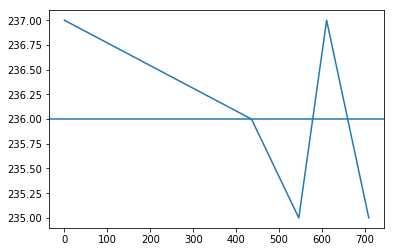

In [4]:
# grating 1 (150 g/mm Bz 800)

d_grating = 1e6/150 #nm /groove

wl_center_data = np.array([
[0,     237],
[435.8,  236],
[546,   235],
[610.8, 237],
[709, 235],
])
    
n0 = np.mean(wl_center_data[:,1])
n0    
plt.figure()
plt.plot(wl_center_data[:,0], wl_center_data[:,1])
plt.axhline(n0)

In [5]:
dispersion_data = np.array([
#wl_actual, wl_center, pixel
[435.8, 484.990, 92],
[435.8, 379.990, 400],
    
[709, 779.99, 25],
[709, 619.98, 498],

#[610.8, 670, 62.63],
#[610.8, 529.9, 474],

[546, 609.990,48],
[546, 479.990,429],
    
[871.8, 930, 63],
[871.8, 800, 446.14],

])


In [6]:
initial_guess = (300e6,1,0.5,0)

kwargs = dict(
    px=dispersion_data[:,2], 
    n0=np.mean(wl_center_data[:,1]),
    wl_center=dispersion_data[:,1], # nm
    m_order=1,
    d_grating=d_grating, # nm
    x_pixel=16e3, #nm
    wl_actual=dispersion_data[:,0], # nm
    offset_adjust = 0
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs)
result.x


kwargs = dict(
    px=dispersion_data[:,2], 
    #px=wl_center_data[:,1],
    n0=np.mean(wl_center_data[:,1]),
    wl_center=dispersion_data[:,1],
    #wl_center=wl_center_data[:,0]*1e-6,
    m_order=1,
    d_grating=1/150.*1e6, # nm
    x_pixel=16e3, #nm
    #wl_actual=dispersion_data[:,0]*1e-6,
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
    offset_adjust = 0,
    curvature = result.x[3]
)

wl_p_calib_p2(**kwargs) - dispersion_data[:,0]


# to store for ini file
# f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature
Y = 'f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature'.split(', ')
print(str([ kwargs[x] for x in Y ]))

[277066040.0390625, 0.44363260294548978, 0.33494964317950504, 236.0, 0, 6666.666666666667, 16000.0, 1.4783653315666176e-05]


# grating 2 (1200 g/mm Bz 750)

In [17]:
d_grating = 1e6/1200 #

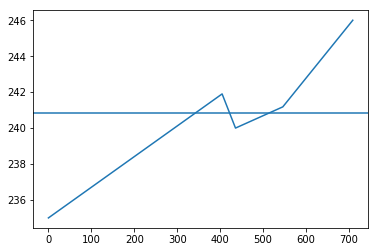

In [18]:
wl_center_data = np.array([
[0,     235],
[404.6, 241.9],
[435.8, 240],
[546, 241.18],
[709, 246],
])
    
n0 = np.mean(wl_center_data[:,1])
plt.figure(2)
plt.plot(wl_center_data[:,0], wl_center_data[:,1])
plt.axhline(n0)

In [29]:
dispersion_data = np.array([
#wl_actual, wl_center, pixel
[709, 716, 36],
[709, 701, 483],
    
[546, 554.5, 11.1],
[546, 537, 487.72],

[435.8, 444.5, 13.8],
#[435.8, 429, 417.21],
[435.8, 426, 496.0],
    
[404.6, 412, 50.3],
[404.6, 396, 463.3],

    
[610.8, 619, 24.06],
[610.8, 602,503.52]
    
])

In [30]:
initial_guess = (300e6,1,0.5,0)

kwargs = dict(
    px=dispersion_data[:,2], 
    n0=np.mean(wl_center_data[:,1]),
    wl_center=dispersion_data[:,1], # nm
    m_order=1,
    d_grating=d_grating, # nm
    x_pixel=16e3, #nm
    wl_actual=dispersion_data[:,0], # nm
    offset_adjust = 0
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs)
result.x

array([  3.75000000e+08,   2.82318517e-01,   5.60729352e-01,
        -1.89289720e-06])

In [32]:
kwargs = dict(
    px=dispersion_data[:,2], 
    #px=wl_center_data[:,1],
    n0=np.mean(wl_center_data[:,1]),
    wl_center=dispersion_data[:,1],
    #wl_center=wl_center_data[:,0]*1e-6,
    m_order=1,
    d_grating=d_grating, # nm
    x_pixel=16e3, #nm
    #wl_actual=dispersion_data[:,0]*1e-6,
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
    offset_adjust = 0,
    curvature = result.x[3]
)

wl_p_calib_p2(**kwargs) - dispersion_data[:,0]


# to store for ini file
# f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature
Y = 'f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature'.split(', ')
print(str([ kwargs[x] for x in Y ]))

[375000000.0, 0.2823185168987965, 0.56072935153553727, 240.81599999999997, 0, 833.3333333333334, 16000.0, -1.8928971957247769e-06]


# grating #3  (Bz = 750nm)

In [33]:
d_grating = 1e6/300. #nm/groove

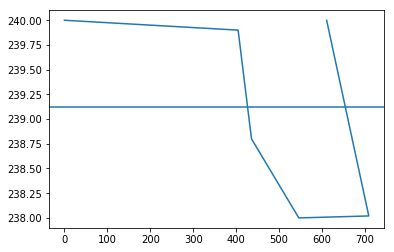

In [34]:
wl_center_data = np.array([
[0,     240],
[404.6, 239.9],
[435.8, 238.8],
[546, 238],
[709, 238.02],
[610.8,240],
])
    
n0 = np.mean(wl_center_data[:,1])
plt.figure(2)
plt.plot(wl_center_data[:,0], wl_center_data[:,1])
plt.axhline(n0)

In [35]:
dispersion_data = np.array([
#wl_actual, wl_center, pixel
[709, 739.99, 51.70],
[709, 670, 472],
    
[546, 579, 42.01],
[546, 502, 501],

[435.8, 475, 8],
[435.8, 391.99, 499],
    
[404.6, 425.99, 113.46],
[404.6, 380, 385.3],
    
[809.4, 840, 50.25],
[809.4, 780, 415.52],
    
[610.8, 579.99, 425.13],
[610.8, 569.99, 484.96],
[610.8, 639.99, 65.3],  
[610.8, 644.99, 5],
[610.8, 639.99, 66],

])

In [36]:
initial_guess = (300e6,1,0.5,0)

kwargs = dict(
    px=dispersion_data[:,2], 
    n0=np.mean(wl_center_data[:,1]),
    wl_center=dispersion_data[:,1], # nm
    m_order=1,
    d_grating=d_grating, # nm
    x_pixel=16e3, #nm
    wl_actual=dispersion_data[:,0], # nm
    offset_adjust = 0
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs)
result.x


kwargs = dict(
    px=dispersion_data[:,2], 
    #px=wl_center_data[:,1],
    n0=np.mean(wl_center_data[:,1]),
    wl_center=dispersion_data[:,1],
    #wl_center=wl_center_data[:,0]*1e-6,
    m_order=1,
    d_grating=d_grating, # nm
    x_pixel=16e3, #nm
    #wl_actual=dispersion_data[:,0]*1e-6,
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
    offset_adjust = 0,
    curvature = result.x[3]
)

wl_p_calib_p2(**kwargs) - dispersion_data[:,0]


# to store for ini file
# f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature
Y = 'f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature'.split(', ')
print(str([ kwargs[x] for x in Y ]))

[300585937.49999994, 0.048725351032290587, 0.69569783942676733, 239.12, 0, 3333.3333333333335, 16000.0, 1.0677989900233526e-05]
